<a href="https://colab.research.google.com/github/qortmdgh4141/Comparing-the-Effect-of-Transfer-Learning-on-ResNet-for-Classification-Problems/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**1. 패키지 설정**

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
# colab에서 기본적으로 제공하지 않는 라이브러리 설치
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
import os
import gc
import time
import onnx
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary

from PIL import Image
from PIL import ImageFile

####**2. 데이터 준비**

In [ ]:
# 데이터셋 불러오기
zip_path = '/content/drive/MyDrive/Colab Notebooks/Github_Repository/custom_korean_family_dataset_resolution_128.zip'
output_dir = '/content/drive/MyDrive/Colab Notebooks/Github_Repository/custom_dataset'

if os.path.exists(output_dir):
    print("이미 파일의 압축을 해제를 수행하였습니다.")
else:
    print("파일의 압축을 해제를 수행합니다.")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

이미 파일의 압축을 해제를 수행하였습니다.


In [ ]:
"""
[Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"

Training dataset: (F0001 ~ F0299) folders have 10,025 images.
Validation dataset: (F0801 ~ F0850) folders have 1,539 images.
Test dataset: (F0851 ~ F0900) folders have 1,504 images.'''
"""
def parsing(meta_data):
    image_age_list = []

    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])

    return image_age_list

In [ ]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # process the meta data
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_meta_data_path = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/custom_dataset/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/custom_dataset/train_images"

val_meta_data_path = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/custom_dataset/custom_val_dataset.csv"
val_meta_data = pd.read_csv(val_meta_data_path)
val_image_directory = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/custom_dataset/val_images"

test_meta_data_path = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/custom_dataset/custom_test_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/custom_dataset/test_images"

'''
[ 데이터 전처리 작업 정의 ]
1) Resize() : 이미지의 크기를 128x128로 잘라내는 작업
2) RandomHorizontalFlip() : 무작위로 이미지를 수평으로 뒤집는 작업 ==> 데이터 증강을 위해 사용되며, 이미지의 좌우 대칭을 통해 다양한 시각적 특성을 학습 가능
3) ToTensor() : PIL 이미지 또는 NumPy 배열 형태의 이미지를 PyTorch 텐서로 변환
4) Normalize() : 이미지의 각 채널을 평균과 표준편차를 사용하여 0과 1 사이의 범위로 변환 : 각 채널별 평균 값과 표준편차 값은 0.5로 설정
'''

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 배치 사이즈 정의
batch_size=512

# 학습 Dataset 인스턴스 생성 후, DataLoader 인스턴스 정의
train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 검증 Dataset 인스턴스 생성 후, DataLoader 인스턴스 정의
val_dataset = Dataset(val_meta_data, val_image_directory, val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 테스트 Dataset 인스턴스 생성 후, DataLoader 인스턴스 정의
test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(f"학습 데이터셋 개수 : {len(train_dataset)}개")
print(f"검증 데이터셋 개수 : {len(val_dataset)}개")
print(f"테스트 데이터셋 개수 : {len(test_dataset)}개")

학습 데이터셋 개수 : 10025개
검증 데이터셋 개수 : 1539개
테스트 데이터셋 개수 : 1504개


In [ ]:
train_data_iter = iter(train_loader)
train_input_data, train_labels = next(train_data_iter)

val_data_iter = iter(val_loader)
val_input_data, val_labels = next(val_data_iter)

test_data_iter = iter(test_loader)
test_input_data, test_labels = next(test_data_iter)

print("학습 데이터의 입력 & 라벨 형상:", train_input_data.shape, '&', train_labels.shape)
print("검증 데이터의 입력 & 라벨 형상:", val_input_data.shape, '&', val_labels.shape)
print("테스트 데이터의 입력 & 라벨 형상:", test_input_data.shape, '&', test_labels.shape)

학습 데이터의 입력 & 라벨 형상: torch.Size([512, 3, 128, 128]) & torch.Size([512])
검증 데이터의 입력 & 라벨 형상: torch.Size([512, 3, 128, 128]) & torch.Size([512])
테스트 데이터의 입력 & 라벨 형상: torch.Size([512, 3, 128, 128]) & torch.Size([512])


ValueError: ignored

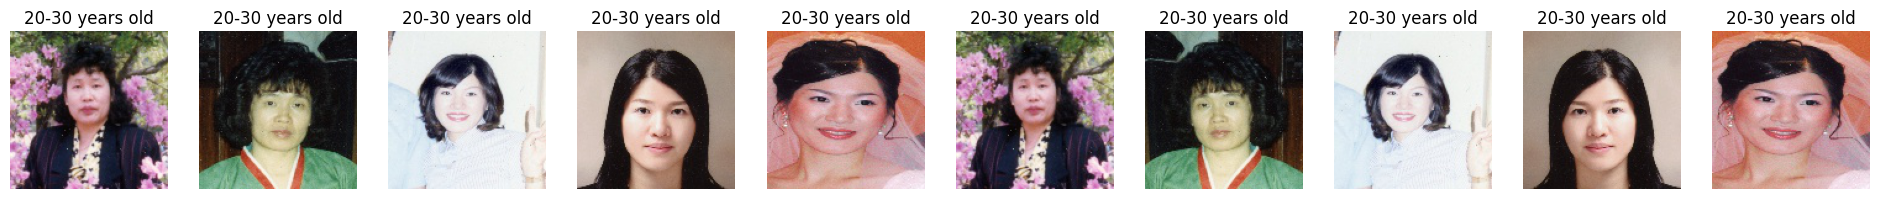

In [ ]:
# 8개의 이미지와 목표 변수(클래스)를 그래프로 출력
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

plot_count = 0
classes_seen = set()
plt.figure(figsize=(24, 4))

for i in range(len(train_dataset)):
    if plot_count == 8:
        break

    image, label = train_loader.dataset[i]
    image = np.transpose(image, (1, 2, 0))
    image = (image + 1) / 2  # -1~1 범위를 0~1 범위로 변환

    class_name = label_to_age[label]

    if class_name not in classes_seen:
        plt.subplot(1, 10, plot_count+1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

        classes_seen.add(class_name)
        plot_count += 1

plt.show() # 그래프 출력

####**3. 탐색적 데이터 분석**

In [ ]:
# 입력 데이터의 차원 변환 : 3차원(이미지 수, 3, 128, 128) -> 2차원 (이미지 수, 3*128*128)
images = np.empty((len(train_dataset), 3, 128, 128), dtype=np.float32)
labels = np.empty(len(train_dataset), dtype=np.int64)

for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    images[i] = image
    labels[i] = label

x_train_reshaped = images.reshape(len(images), 128*128*3)

# 데이터 프레임으로 변형하여 널 값의 빈도 확인
x_train_df = pd.DataFrame(x_train_reshaped)
total_null_count = x_train_df.isnull().sum().sum()

print(f"널값의 개수 : {total_null_count}개")

In [ ]:
# 목표변수의 라벨별 빈도 계산 후 데이터 프레임으로 변환
y_cnt = pd.DataFrame(labels).value_counts()
df = pd.DataFrame(y_cnt, columns=['Count'])

# 인덱스 리셋 및 문자열로 변환
df.reset_index(inplace=True)
df['Label'] = list(label_to_age.values())

# 컬러맵 설정 및 바차트 생성
cmap = plt.cm.Set3
fig, ax = plt.subplots(figsize=(16, 3))
bars = ax.bar(df['Label'], df['Count'], color=cmap(np.arange(len(df))))

# 바 위에 라벨 갯수 출력
for i, count in enumerate(df['Count']):
    ax.text(i, count + 100, str(count), ha='center', fontsize=7)

# 그래프 레이블과 제목 설정 및  y축 범위 늘리기 (현재 최댓값의 110%로 범위 지정)
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')
ax.set_title('Label Counts')
ax.set_ylim(0, df['Count'].max() * 1.1)

plt.show() # 그래프 출력

####**4. ResNet50 모델 아키텍처 정의**

In [24]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    r"""
    3x3 convolution with padding
    - in_planes: in_channels
    - out_channels: out_channels
    - bias=False: BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정.
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):
    expansion = 4 # 블록 내에서 차원을 증가시키는 3번째 conv layer에서의 확장계수

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        # ResNext나 WideResNet의 경우 사용
        width = int(planes * (base_width / 64.)) * groups

        # Bottleneck Block의 구조
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        # conv2에서 downsample
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        # 1x1 convolution layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 3x3 convolution layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # 1x1 convolution layer
        out = self.conv3(out)
        out = self.bn3(out)

        # skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, groups=1, width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        super(ResNet50, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self._norm_layer = norm_layer
        # input feature map
        self.inplanes = 64
        self.dilation = 1

        # stride를 dilation으로 대체할지 선택
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]

        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))

        self.groups = groups
        self.base_width = width_per_group

        r"""
        - 처음 입력에 적용되는 self.conv1과 self.bn1, self.relu는 모든 ResNet에서 동일
        - 3: 입력으로 RGB 이미지를 사용하기 때문에 convolution layer에 들어오는 input의 channel 수는 3
        """
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        r"""
        - 아래부터 block 형태와 갯수가 ResNet층마다 변화
        - self.layer1 ~ 4: 필터의 개수는 각 block들을 거치면서 증가(64->128->256->512)
        - self.avgpool: 모든 block을 거친 후에는 Adaptive AvgPool2d를 적용하여 (n, 512, 1, 1)의 텐서로
        - self.fc: 이후 fc layer를 연결
        """
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, # 여기서부터 downsampling적용
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        r"""
        convolution layer 생성 함수
        - block: block종류 지정
        - planes: feature map size (input shape)
        - blocks: layers[0]와 같이, 해당 블록이 몇개 생성돼야하는지, 블록의 갯수 (layer 반복해서 쌓는 개수)
        - stride와 dilate은 고정
        """
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation

        if dilate:
            self.dilation *= stride
            stride = 1

        # the number of filters is doubled: self.inplanes와 planes 사이즈를 맞춰주기 위한 projection shortcut
        # the feature map size is halved: stride=2로 downsampling
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []

        # 블록 내 시작 layer, downsampling 필요
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion # inplanes 업데이트

        # 동일 블록 반복
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [25]:
# ResNet 50 모델 구조 출력
dummy_model = ResNet50(Bottleneck, [3, 4, 6, 3]).cuda()
summary(dummy_model, input_size = (3 , 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [26]:
# ResNet50 모델 구조 onnx 파일로 저장
path = 'dummy_model_output.onnx'
dummy_model = ResNet50(Bottleneck, [3, 4, 6, 3]).cuda()
dummy_data = torch.empty(1, 3 , 128, 128, dtype=torch.float32).cuda()

torch.onnx.export(dummy_model, dummy_data, path)
onnx.save(onnx.shape_inference.infer_shapes(onnx.load(path)), path)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



#### <b> 5. 전이학습(Transfer Learning)의 미세조정(Fine Tuning) 적용 및 "Train / Validate / Test" 함수 정의</b>

In [ ]:
learning_rate = 0.01
log_step = 1

# 사전 학습된 ResNet50을 가져옴
pretrained_model = models.resnet50(pretrained=True)
num_features = pretrained_model.fc.in_features

org_net = ResNet50(Bottleneck, [3, 4, 6, 3])
org_net.fc = nn.Linear(num_features, 8)
org_net = org_net.to('cuda')
org_criterion = nn.CrossEntropyLoss()
org_optimizer = optim.SGD(org_net.parameters(), lr=learning_rate, momentum=0.9)

trans_net = ResNet50(Bottleneck, [3, 4, 6, 3])
trans_net.load_state_dict(pretrained_model.state_dict()) # transfer learning
trans_net.fc = nn.Linear(num_features, 8)
trans_net = trans_net.to('cuda')
trans_criterion = nn.CrossEntropyLoss()
trans_optimizer = optim.SGD(trans_net.parameters(), lr=learning_rate, momentum=0.9)

def train(net, optimizer, criterion, epoch):
    print(f'[Epoch: {epoch + 1} - Training]')

    net.train()

    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_loader):
        imgs, labels = batch
        imgs, labels = imgs.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()

        outputs = net(imgs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'\t\t[Batch: {i + 1} / {len(train_loader)}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    return running_loss / total, (running_corrects / total).item()

def validate(net, criterion, epoch):
    print(f'[Epoch: {epoch + 1} - Validation]')

    net.eval()

    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = net(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'\t\t[Batch: {i + 1} / {len(val_loader)}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')
    print()

    return running_loss / total, (running_corrects / total).item()

def test(net, criterion):
    net.eval()

    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = net(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    return running_loss / total, (running_corrects / total).item()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### <b> 6. Original-ResNet 모델 학습 & 테스트 </b>

In [ ]:
gc.collect()
torch.cuda.empty_cache()
org_train_loss, org_train_acc, org_val_loss, org_val_acc = [], [], [], []

for epoch in range(0, 10):
    train_loss, train_acc = train(net=org_net, optimizer=org_optimizer, criterion=org_criterion, epoch=epoch)
    val_loss, val_acc = validate(net=org_net, criterion=org_criterion, epoch=epoch)

    org_train_loss.append(train_loss)
    org_train_acc.append(train_acc)
    org_val_loss.append(val_loss)
    org_val_acc.append(val_acc)

#### <b> 7. TL-ResNet(ResNet model based on transfer learning) 모델 학습 & 테스트 </b>

In [ ]:
gc.collect()
torch.cuda.empty_cache()
trans_train_loss, trans_train_acc, trans_val_loss, trans_val_acc = [], [], [], []

for epoch in range(0, 10):
    train_loss, train_acc = train(net=trans_net, optimizer=trans_optimizer, criterion=trans_criterion, epoch=epoch)
    val_loss, val_acc = validate(net=trans_net, criterion=trans_criterion, epoch=epoch)

    trans_train_loss.append(train_loss)
    trans_train_acc.append(train_acc)
    trans_val_loss.append(val_loss)
    trans_val_acc.append(val_acc)

[Epoch: 1 - Training]
		[Batch: 1 / 20] running train loss: 0.004239452537149191, running train accuracy: 0.1171875
		[Batch: 2 / 20] running train loss: 0.00409115687943995, running train accuracy: 0.1748046875
		[Batch: 3 / 20] running train loss: 0.003945850223923723, running train accuracy: 0.201171875
		[Batch: 4 / 20] running train loss: 0.003875458030961454, running train accuracy: 0.23583984375
		[Batch: 5 / 20] running train loss: 0.0038352773059159516, running train accuracy: 0.2542968690395355
		[Batch: 6 / 20] running train loss: 0.003770364564843476, running train accuracy: 0.2744140625
		[Batch: 7 / 20] running train loss: 0.003701277941997562, running train accuracy: 0.2926897406578064
		[Batch: 8 / 20] running train loss: 0.0036268469993956387, running train accuracy: 0.305419921875
		[Batch: 9 / 20] running train loss: 0.003565085275719563, running train accuracy: 0.3138020932674408
		[Batch: 10 / 20] running train loss: 0.003514730208553374, running train accuracy: 0.

In [ ]:
# 모델 저장
torch.save(trans_net, "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet_model.pt")

#### <b> 8. Orginal-ResNet vs TL-ResNet 모델 비교 </b>

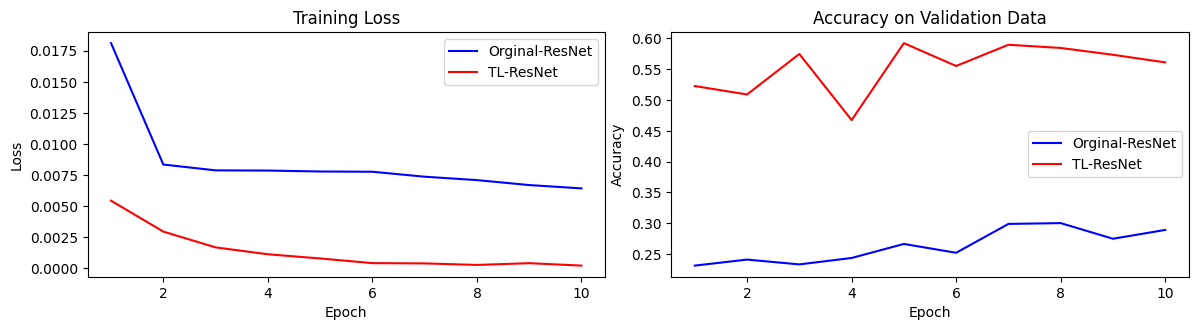

In [ ]:
def plot_loss_and_accuracy(org_train_loss, trans_train_loss, org_val_acc, trans_val_acc):
    epochs = range(1, len(org_train_loss) + 1)

    plt.figure(figsize=(12, 6))

    # Loss 그래프
    plt.subplot(2, 2, 1)
    plt.plot(epochs, org_train_loss, 'b', label='Orginal-ResNet')
    plt.plot(epochs, trans_train_loss, 'r', label='TL-ResNet')
    plt.title(f'Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(2, 2, 2)
    plt.plot(epochs, org_val_acc, 'b', label='Orginal-ResNet')
    plt.plot(epochs, trans_val_acc, 'r', label='TL-ResNet')
    plt.title(f'Accuracy on Validation Data')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    plt.show()

# 그래프 출력
plot_loss_and_accuracy(org_train_loss, trans_train_loss, org_val_acc, trans_val_acc)

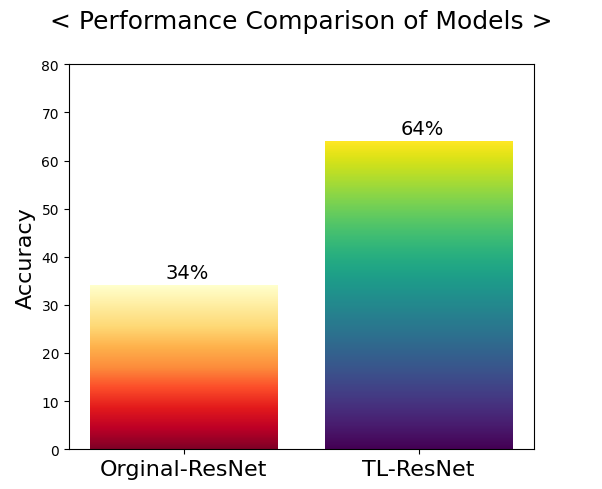

In [ ]:
def gradientbars(bars, cmap_list):
    # cmap 가중치 설정
    grad = np.atleast_2d(np.linspace(0,1,256)).T
    # 플롯 영역 재설정
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    # 각 막대에 색 입히기
    max = 0
    for i, bar in enumerate(bars):
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x,x+w,y,y+h], aspect="auto", cmap=cmap_list[i])

        plt.text(x+w/2.0+0.015, h+0.7, "{}%".format(h), fontsize=14, ha='center', va='bottom')

_, org_test_acc = test(net=org_net, criterion=org_criterion)
_, trans_test_acc = test(net=trans_net, criterion=trans_criterion)

df = pd.DataFrame({'Model':['Orginal-ResNet', 'TL-ResNet'], 'Accuracy': [round(org_test_acc*100) , round(trans_test_acc*100)]})

fig, ax = plt.subplots(figsize=(6,5))
cmap_color = ['viridis_r', 'YlOrRd']
gradientbars(ax.bar(df.Model, df.Accuracy), cmap_color)

plt.title("     < Performance Comparison of Models >     \n", fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([0, 80])
plt.xticks(fontsize=16)

plt.show()

#### <b> 9. 실제 연예인 이미지 테스트 </b>

In [125]:
from PIL import ImageFile

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform = None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        img = Image.open(image_path)

        channels = len(img.getbands())
        if channels == 4:
            img = img.convert("RGB")  # 알파 채널을 제외하고 RGB로 변환

        if self.transform:
            img = self.transform(img)
        return img

def real_img_test(net, loader):
    net.eval()

    pred_list = []
    for i, batch in enumerate(loader):
        imgs = batch
        imgs = imgs.cuda()

        with torch.no_grad():
            outputs = net(imgs)
            _, preds = torch.max(outputs, 1)

        pred_list.append(preds.item())

    return pred_list

label_to_age = {
    0: "Kids \n (0~9 years old)",
    1: "Young Adults \n (Teens : 13~19 years old)",
    2: "Young Adults \n (Twenties : 20~29 years old)",
    3: "Young Adults \n (Thirties : 30~39 years old)",
    4: "Middle-aged Adults \n (Forties : 40-49 years old)",
    5: "Middle-aged Adults \n (Fifties : 50-59 years old)",
    6: "Old Adults \n (Sixties : 60-69 years old)",
    7: "Old Adults \n (Seventies and Older : 70~)"
}

real_test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

ImageFile.LOAD_TRUNCATED_IMAGES = True

image_paths = ["/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img1.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img2.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img3.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img4.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img5.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img6.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img7.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img8.png"]

names = ["[ Chu Sarang ]", "[ Jang Wonyoung ]", "[ Me ]\n(Baek Seungho)", "[ Swings ]", "[ Lee Jungjae ]", "[ Ryu Seungryong ]", "[ Na Moonhee ]", "[ Kim Youngok ]"]

real_dataset = CustomDataset(image_paths, real_test_transform)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=1, shuffle=False)

model_path = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/TL-ResNet_model.pt" # 모델 파일 경로

trans_net = torch.load(model_path)

pred_list = real_img_test(net=trans_net, loader=real_dataloader)
pred_ages = [label_to_age[pred] for pred in pred_list]

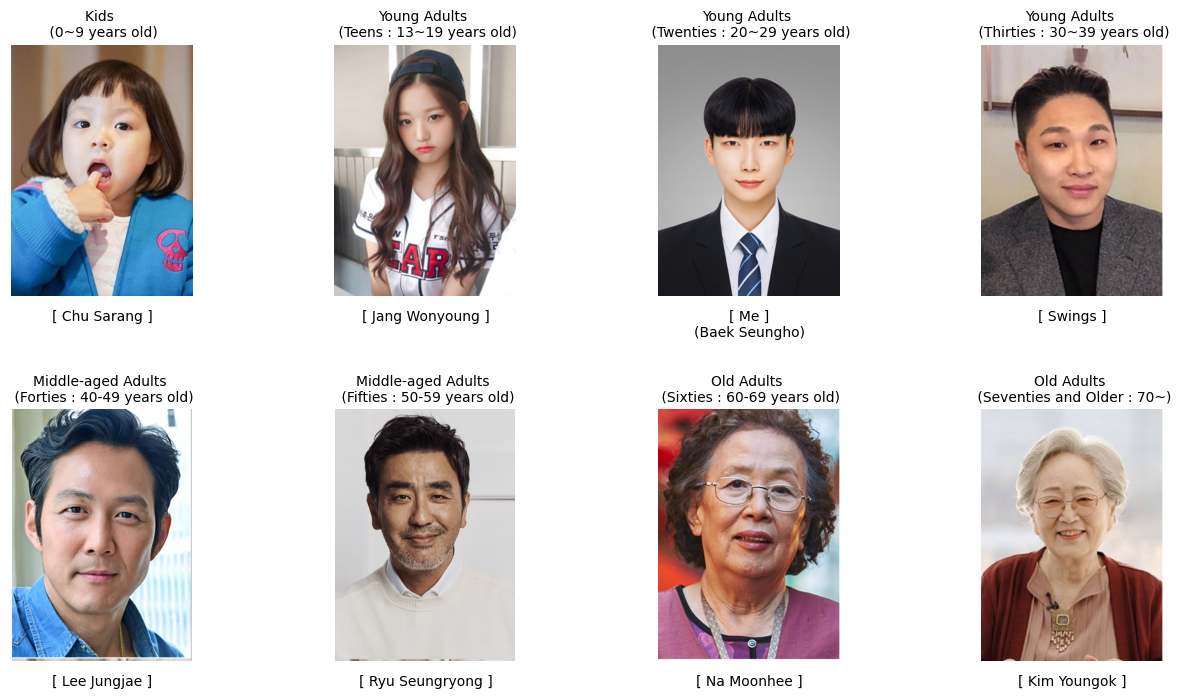

In [126]:
# 이미지와 라벨 출력을 위한 함수 정의
def plot_images_with_labels(image_paths, names, pred_ages):
    num_images = len(image_paths)
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))

    plt.subplots_adjust(hspace=0.45)

    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        label = pred_ages[i]

        row = i // 4
        col = i % 4
        axs[row, col].imshow(image)
        axs[row, col].set_title(f"{label}", fontsize=10)
        axs[row, col].axis('off')

        label_x = image.size[0] / 2  # 이미지의 가로 중앙으로 텍스트를 이동시킵니다.
        label_y = image.size[1]  # 이미지의 아래에 텍스트를 표시합니다.
        axs[row, col].text(label_x, label_y+20, names[i], fontsize=10, ha='center', va='top')  # 이미지 밑에 라벨을 추가합니다.

    plt.show()

# 이미지와 라벨을 그래프에 출력
plot_images_with_labels(image_paths , names, pred_ages)